In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [410]:
# numeric imports
import torch
import numpy as np
# gpytorch imports
import gpytorch
from src.models.sparse.gridded_kronecker_structure import GriddedMatern12ExactGP, GriddedMatern12SVGP, GriddedMatern12ASVGP, GriddedMatern12VFFGP, Matern12GriddedGP
# utils imports
from src.utils.experiments import load_gulf_stream_data
from src.utils.dataprocessors import z_scaling, min_max_scaling
from src.utils.evaluationmetrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r_squared, negative_log_predictive_density, mean_squared_log_loss
from src.utils.misc import make_training_history_dict, cross_validation_dict, evaluation_metric_row
from src.utils.plotting import plot_model_history
# experiment imports
from experiments.gulfstream.experiment_dictionaries import EXP_1_TRAIN, EXP_1_VAL, EXP_1_TEST
# plotting imports
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
# data imports 
import pandas as pd
# misc imports
from torch.linalg import LinAlgError
from tqdm import tqdm
from typing import Tuple, List, Dict
import os

In [126]:
plt.style.use('tableau-colorblind10')

In [127]:
# META
OBS_ROOT_FOLDER = 'data/dc_obs'
REF_ROOT_FOLDER = 'data/dc_ref'
SPARISTY = 3
EXTENT = [-65, -55, 33, 43]

In [399]:
train_start_date = EXP_1_TRAIN['YEAR_FRAME'][0] + '-' + EXP_1_TRAIN['MONTH_FRAME'][0] + '-' + EXP_1_TRAIN['DAY_FRAME'][0] + ' ' + EXP_1_TRAIN['HOUR_FRAME'][0]
train_end_date = EXP_1_TEST['YEAR_FRAME'][1] + '-' + EXP_1_TEST['MONTH_FRAME'][1] + '-' + EXP_1_TEST['DAY_FRAME'][1] + ' ' + EXP_1_TEST['HOUR_FRAME'][1]

In [412]:
# make results folder
results_root_path = 'results/gulfstream'
experiment_name = 'experiment_1_' + EXP_1_TRAIN['SATELLITE'] + '_' +  train_start_date + '_' + train_end_date
# make results folder
results_path = os.path.join(results_root_path, experiment_name)
if not os.path.exists(results_path):
    os.makedirs(results_path)
else:
    print('Warning: results folder already exists')
    

# Data

In [264]:
# LOAD DATA
ds_train = load_gulf_stream_data(OBS_ROOT_FOLDER, REF_ROOT_FOLDER, EXP_1_TRAIN)
ds_val = load_gulf_stream_data(OBS_ROOT_FOLDER, REF_ROOT_FOLDER, EXP_1_VAL)
ds_test = load_gulf_stream_data(OBS_ROOT_FOLDER, REF_ROOT_FOLDER, EXP_1_TEST)

# train, test sets
X_train, y_train = ds_train.obs_train_data(SPARISTY)
X_val, y_val = ds_val.obs_train_data(SPARISTY)
X_test, y_test = ds_test.obs_train_data(SPARISTY)


**Training Data**

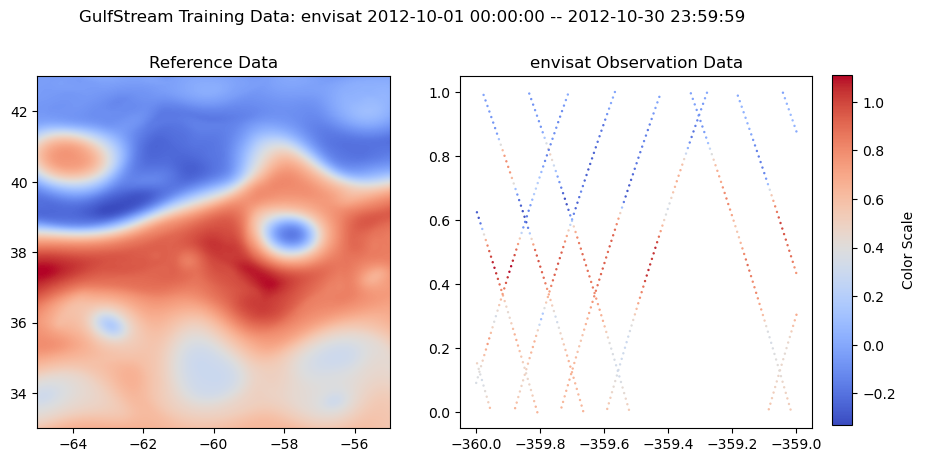

In [416]:
train_start_date = EXP_1_TRAIN['YEAR_FRAME'][0] + '-' + EXP_1_TRAIN['MONTH_FRAME'][0] + '-' + EXP_1_TRAIN['DAY_FRAME'][0] + ' ' + EXP_1_TRAIN['HOUR_FRAME'][0]
train_end_date = EXP_1_TEST['YEAR_FRAME'][1] + '-' + EXP_1_TEST['MONTH_FRAME'][1] + '-' + EXP_1_TEST['DAY_FRAME'][1] + ' ' + EXP_1_TEST['HOUR_FRAME'][1]
plot_title = 'GulfStream Training Data: {} {} -- {}'.format(EXP_1_TRAIN['SATELLITE'], train_start_date, train_end_date)
# plot training data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(plot_title)
# plot ref data
ax1.set_title('Reference Data')
ax1.imshow(ds_train.ref_data_avg_across_time.sossheig.values, origin = 'lower', cmap='coolwarm', extent = EXTENT)
# plot the obs data
ax2.set_title('{} Observation Data'.format(EXP_1_TRAIN['SATELLITE']))
scatter = ax2.scatter(X_train[:, 0] - 360., X_train[:, 1], c = y_train, cmap = 'coolwarm', s = 0.5) # -360 to convert from 0-360 to -180-180 on the longitude axis
# Add colorbar for the scatter plot
# Create a separate axis for the color bar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax)
cbar.set_label('Color Scale')
# Adjust the aspect ratio of the scatter plot to match imshow's extent
scatter_aspect = (EXTENT[1] - EXTENT[0]) / (EXTENT[3] - EXTENT[2])
ax2.set_aspect(scatter_aspect)

In [418]:
fig.savefig(os.path.join(results_path, plot_title))


**Validation Data**

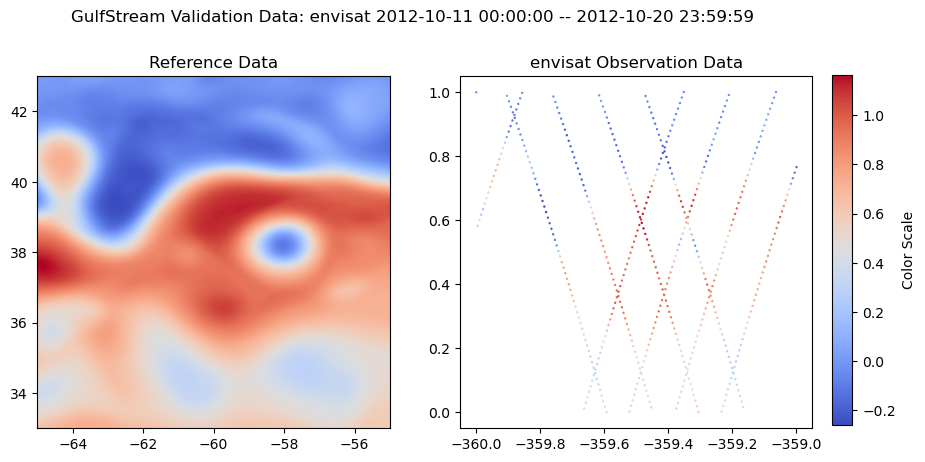

In [419]:
val_start_date = EXP_1_VAL['YEAR_FRAME'][0] + '-' + EXP_1_VAL['MONTH_FRAME'][0] + '-' + EXP_1_VAL['DAY_FRAME'][0] + ' ' + EXP_1_VAL['HOUR_FRAME'][0]
val_end_date = EXP_1_VAL['YEAR_FRAME'][1] + '-' + EXP_1_VAL['MONTH_FRAME'][1] + '-' + EXP_1_VAL['DAY_FRAME'][1] + ' ' + EXP_1_VAL['HOUR_FRAME'][1]
plot_title = 'GulfStream Validation Data: {} {} -- {}'.format(EXP_1_VAL['SATELLITE'], val_start_date, val_end_date)
# plot training data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(plot_title)
# plot ref data
ax1.set_title('Reference Data')
ax1.imshow(ds_val.ref_data_avg_across_time.sossheig.values, origin = 'lower', cmap='coolwarm', extent = EXTENT)
# plot the obs data
ax2.set_title('{} Observation Data'.format(EXP_1_VAL['SATELLITE']))
scatter = ax2.scatter(X_val[:, 0] - 360., X_val[:, 1], c = y_val, cmap = 'coolwarm', s = 0.5) # -360 to convert from 0-360 to -180-180 on the longitude axis
# Add colorbar for the scatter plot
# Create a separate axis for the color bar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax)
cbar.set_label('Color Scale')
# Adjust the aspect ratio of the scatter plot to match imshow's extent
scatter_aspect = (EXTENT[1] - EXTENT[0]) / (EXTENT[3] - EXTENT[2])
ax2.set_aspect(scatter_aspect)

In [420]:
fig.savefig(os.path.join(results_path, plot_title))

**Testing Data**

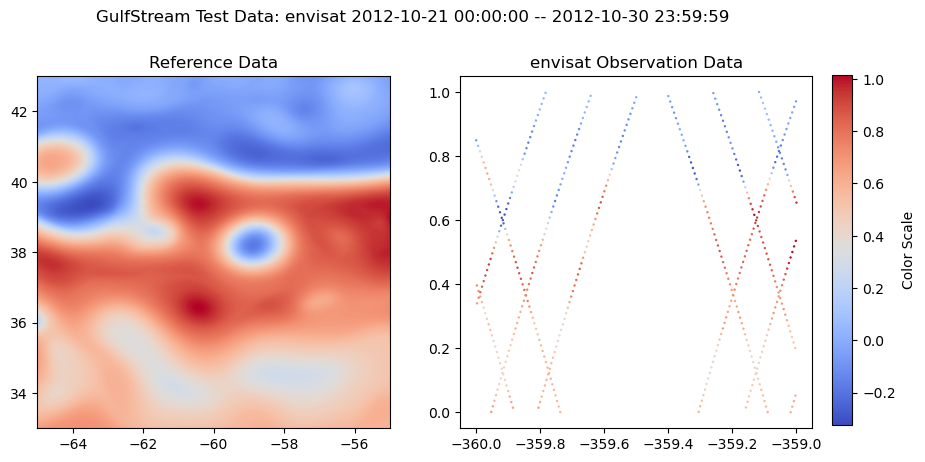

In [421]:
test_start_date = EXP_1_TEST['YEAR_FRAME'][0] + '-' + EXP_1_TEST['MONTH_FRAME'][0] + '-' + EXP_1_TEST['DAY_FRAME'][0] + ' ' + EXP_1_TEST['HOUR_FRAME'][0]
test_end_date = EXP_1_TEST['YEAR_FRAME'][1] + '-' + EXP_1_TEST['MONTH_FRAME'][1] + '-' + EXP_1_TEST['DAY_FRAME'][1] + ' ' + EXP_1_TEST['HOUR_FRAME'][1]
plot_title = 'GulfStream Test Data: {} {} -- {}'.format(EXP_1_VAL['SATELLITE'], test_start_date, test_end_date)
# plot training data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(plot_title)
# plot ref data
ax1.set_title('Reference Data')
ax1.imshow(ds_test.ref_data_avg_across_time.sossheig.values, origin = 'lower', cmap='coolwarm', extent = EXTENT)
# plot the obs data
ax2.set_title('{} Observation Data'.format(EXP_1_VAL['SATELLITE']))
scatter = ax2.scatter(X_test[:, 0] - 360., X_test[:, 1], c = y_test, cmap = 'coolwarm', s = 0.5) # -360 to convert from 0-360 to -180-180 on the longitude axis
# Add colorbar for the scatter plot
# Create a separate axis for the color bar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax)
cbar.set_label('Color Scale')
# Adjust the aspect ratio of the scatter plot to match imshow's extent
scatter_aspect = (EXTENT[1] - EXTENT[0]) / (EXTENT[3] - EXTENT[2])
ax2.set_aspect(scatter_aspect)

In [422]:
fig.savefig(os.path.join(results_path, plot_title))

**Grids**

In [142]:
train_grid = ds_train.grid_ref_data_simpson(EXP_1_TRAIN['N_SPLINES'])
val_grid = ds_val.grid_ref_data_simpson(EXP_1_VAL['N_SPLINES'])
test_grid = ds_test.grid_ref_data_simpson(EXP_1_TEST['N_SPLINES'])

In [157]:
train_grid = torch.tensor(train_grid)
val_grid = torch.tensor(val_grid)
test_grid = torch.tensor(test_grid)

**Normalising Data**

In [265]:
# training data
X_train[:, 0], x1_train_mu, x1_train_std = min_max_scaling(X_train[:, 0])
X_train[:, 1], x2_train_mu, x2_train_std = min_max_scaling(X_train[:, 1])
# validation data
X_val[:, 0], x1_val_mu, x1_val_std = min_max_scaling(X_val[:, 0])
X_val[:, 1], x2_val_mu, x2_val_std = min_max_scaling(X_val[:, 1])
# test data
X_test[:, 0], x1_test_mu, x1_test_std = min_max_scaling(X_test[:, 0])
X_test[:, 1], x2_test_mu, x2_test_std = min_max_scaling(X_test[:, 1])


# Training

In [266]:
N_B0_SPLINES = EXP_1_TRAIN['N_SPLINES']
DIM1_GRID_LIMS = (0, 1)
DIM2_GRID_LIMS = (0, 1)
N_ITER = 1000
LEARNING_RATE = 0.01
CV_LR = 0.1
CV_ITERATIONS = 100

**Exact GP**

In [267]:
exactgp = GriddedMatern12ExactGP(
                        train_x = X_train, train_y = y_train,   
                        n_b0_splines = N_B0_SPLINES,
                        dim1_grid_lims = DIM1_GRID_LIMS, dim2_grid_lims = DIM2_GRID_LIMS,).to(torch.float64)

In [268]:
exactgp_history = make_training_history_dict(N_ITER)
exactgp_history['learning_rate'] = LEARNING_RATE

In [269]:
# set model and likelihood into training mode
exactgp.train()
exactgp.likelihood.train()
# define the optimizer
optimizer = torch.optim.Adam(exactgp.parameters(), lr = LEARNING_RATE)
# define the mll
mll = gpytorch.mlls.ExactMarginalLogLikelihood(exactgp.likelihood, exactgp)
for i in tqdm(range(N_ITER)):
    optimizer.zero_grad()
    output = exactgp(exactgp.train_x)
    loss = -mll(output, exactgp.train_y)
    scale_sigma_1 = exactgp.kernel_1.outputscale.item()
    scale_sigma_2 = exactgp.kernel_2.outputscale.item()
    lengthscale_1 = exactgp.kernel_1.base_kernel.lengthscale.item()
    lengthscale_2 = exactgp.kernel_2.base_kernel.lengthscale.item()
    noise = exactgp.likelihood.noise.item()
    # add to history
    exactgp_history['loss'][i] = loss.item()
    exactgp_history['scale_sigma_1'][i] = scale_sigma_1
    exactgp_history['scale_sigma_2'][i] = scale_sigma_2
    exactgp_history['lengthscale_1'][i] = lengthscale_1
    exactgp_history['lengthscale_2'][i] = lengthscale_2
    exactgp_history['noise'][i] = noise
    # take step
    loss.backward()
    optimizer.step()

100%|██████████| 1000/1000 [00:19<00:00, 51.58it/s]


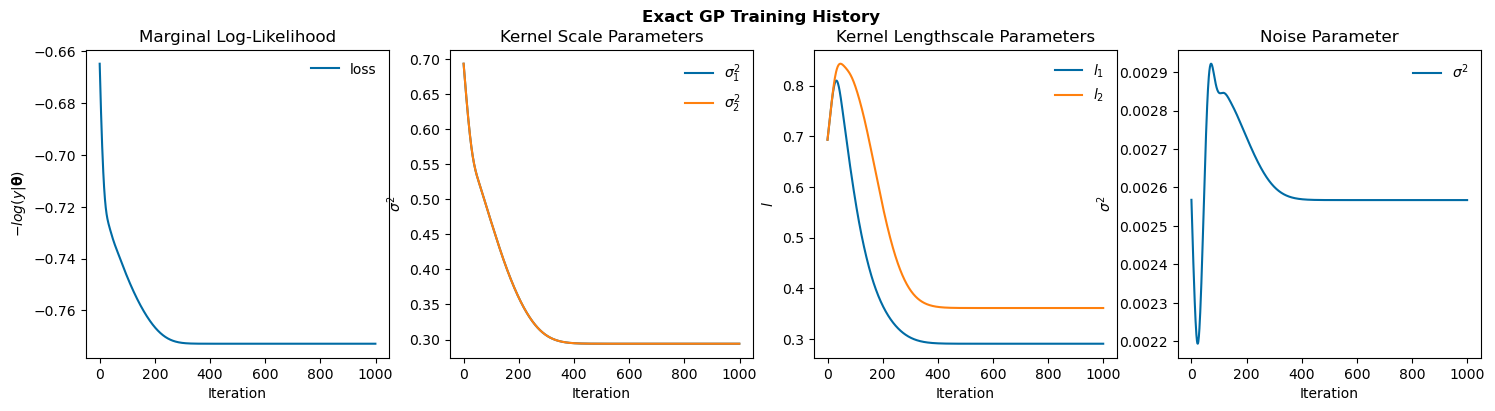

In [423]:
exact_gp_training_fig = plot_model_history(exactgp_history, 'Exact GP')

In [427]:
exact_gp_training_fig.savefig(os.path.join(results_path, 'exactgp_training_history.png'))

**SVGP**

In [296]:
cv_Zs = [10, 30, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
svgp_cv_dict = cross_validation_dict(len(cv_Zs))
# Cross Validation 
for i, n_z in enumerate(cv_Zs):
    # create the model
    inducing_points = torch.tensor(np.random.rand(n_z, 2), dtype=torch.float64)
    svgp = GriddedMatern12SVGP(
                    X_train, y_train, inducing_points, # data part
                    n_b0_splines = N_B0_SPLINES, # vff part
                    dim1_grid_lims = DIM1_GRID_LIMS, dim2_grid_lims = DIM2_GRID_LIMS).to(torch.float64) # spline part
    # fit the model
    optimizer = torch.optim.Adam(svgp.parameters(), lr=CV_LR)
    for _ in tqdm(range(CV_ITERATIONS)):
        optimizer.zero_grad()
        elbow = -svgp._elbo()
        elbow.backward()
        optimizer.step()
    # evaluate the model
    svgp_val = GriddedMatern12SVGP(X_val, y_val, svgp.Z,
                                   N_B0_SPLINES,
                                   DIM1_GRID_LIMS, DIM2_GRID_LIMS).to(torch.float64)
    # set hyperparameters to the values of the trained model
    svgp_val.likelihood.noise = svgp.likelihood.noise
    svgp_val.kernel_1.base_kernel.lengthscale = svgp.kernel_1.base_kernel.lengthscale
    svgp_val.kernel_2.base_kernel.lengthscale = svgp.kernel_2.base_kernel.lengthscale
    svgp_val.kernel_1.outputscale = svgp.kernel_1.outputscale
    svgp_val.kernel_2.outputscale = svgp.kernel_2.outputscale
    
    DELTA = (svgp.b0_mesh_1[1] - svgp.b0_mesh_1[0]) ** 2
    
    grid_true = train_grid * DELTA.item()
    grid_true_val = val_grid * DELTA.item()

    grid_pred = svgp.q_v()
    grid_pred_y = grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T
    
    grid_pred_val = svgp_val.q_v()
    grid_pred_val_y = grid_pred_val.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T
    # loss
    svgp_cv_dict['train_loss'][i] = -svgp._elbo()
    svgp_cv_dict['val_loss'][i] = -svgp_val._elbo()
    # mse
    svgp_cv_dict['train_mse'][i] = mean_squared_error(grid_true, grid_pred_y).item()
    svgp_cv_dict['val_mse'][i] = mean_squared_error(grid_true_val, grid_pred_val_y).item()
    # mae
    svgp_cv_dict['train_mae'][i] = mean_absolute_error(grid_true, grid_pred_y).item()
    svgp_cv_dict['val_mae'][i] = mean_absolute_error(grid_true_val, grid_pred_val_y).item()
    # rmse
    svgp_cv_dict['train_rmse'][i] = root_mean_squared_error(grid_true, grid_pred_y).item()
    svgp_cv_dict['val_rmse'][i] = root_mean_squared_error(grid_true_val, grid_pred_val_y).item()
    # r2
    svgp_cv_dict['train_r2'][i] = r_squared(grid_true, grid_pred_y).item()
    svgp_cv_dict['val_r2'][i] = r_squared(grid_true_val, grid_pred_val_y).item()
    # nlpd
    svgp_cv_dict['train_nlpd'][i] = negative_log_predictive_density(grid_true, grid_pred).item()
    svgp_cv_dict['val_nlpd'][i] = negative_log_predictive_density(grid_true_val, grid_pred_val).item()
    # msll
    svgp_cv_dict['train_msll'][i] = mean_squared_log_loss(grid_true, grid_pred).item()
    svgp_cv_dict['val_msll'][i] = mean_squared_log_loss(grid_true_val, grid_pred_val).item()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
100%|██████████| 100/100 [00:07<00:00, 13.88it/s]


In [297]:
inducing_points = torch.tensor(np.random.rand(100, 2), dtype=torch.float64)
svgp = GriddedMatern12SVGP(
                X_train, y_train, inducing_points, # data part
                n_b0_splines = N_B0_SPLINES, # vff part
                dim1_grid_lims = DIM1_GRID_LIMS, dim2_grid_lims = DIM2_GRID_LIMS).to(torch.float64) # spline part

In [298]:
svgp_history = make_training_history_dict(N_ITER)
svgp_history['learning_rate'] = LEARNING_RATE

In [299]:
# fit the model
optimizer = torch.optim.Adam(svgp.parameters(), lr=LEARNING_RATE)
for i in tqdm(range(N_ITER)):
    # compute loss
    optimizer.zero_grad()
    elbow = -svgp._elbo()
    # add to history
    scale_sigma_1 = svgp.kernel_1.outputscale.item()
    scale_sigma_2 = svgp.kernel_2.outputscale.item()
    lengthscale_1 = svgp.kernel_1.base_kernel.lengthscale.item()
    lengthscale_2 = svgp.kernel_2.base_kernel.lengthscale.item()
    noise = svgp.likelihood.noise.item()
    # add to history
    svgp_history['loss'][i] = elbow.item()
    svgp_history['scale_sigma_1'][i] = scale_sigma_1
    svgp_history['scale_sigma_2'][i] = scale_sigma_2
    svgp_history['lengthscale_1'][i] = lengthscale_1
    svgp_history['lengthscale_2'][i] = lengthscale_2
    svgp_history['noise'][i] = noise
    # take step
    elbow.backward()
    optimizer.step()
    


100%|██████████| 1000/1000 [00:51<00:00, 19.31it/s]


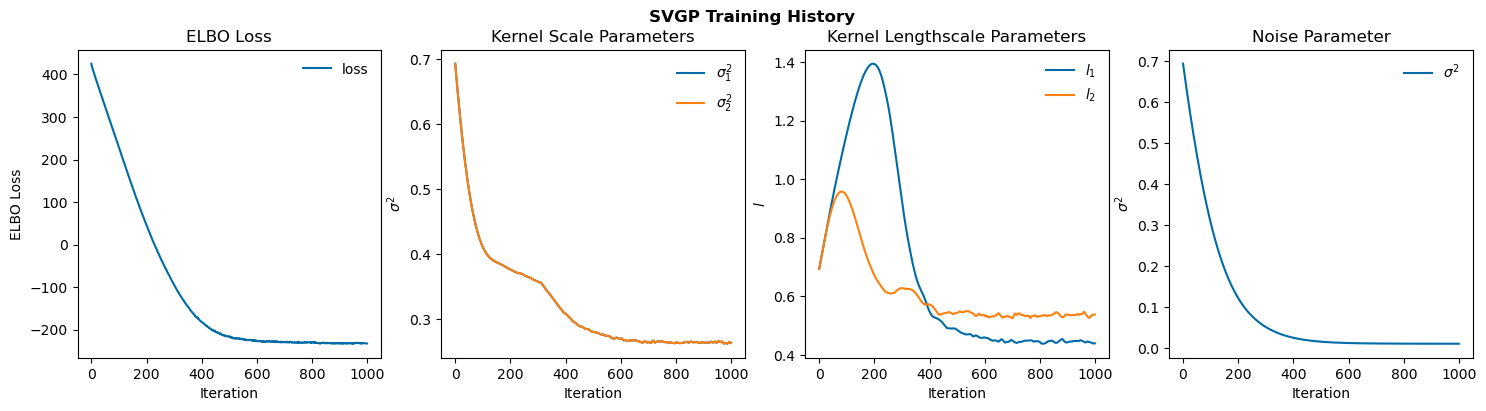

In [429]:
svgp_training_fig = plot_model_history(svgp_history, 'SVGP', elbo_loss=True)

In [430]:
svgp_training_fig.savefig(os.path.join(results_path, 'svgp_training_history.png'))

**VFFGP**

In [320]:
cv_n_omegas = [1, 3, 5, 7, 10, 12]
vffgp_cv_dict = cross_validation_dict(len(cv_n_omegas))
# Cross Validation 
for i, n_omegas in enumerate(cv_n_omegas):
    # create the model
    vffgp = GriddedMatern12VFFGP(
                    X_train, y_train, 
                    n_omegas, DIM1_GRID_LIMS, DIM2_GRID_LIMS,
                    N_B0_SPLINES, DIM1_GRID_LIMS, DIM2_GRID_LIMS).to(torch.float64) # spline part
    # fit the model
    optimizer = torch.optim.Adam(vffgp.parameters(), lr=CV_LR)
    for _ in tqdm(range(CV_ITERATIONS)):
        optimizer.zero_grad()
        elbow = -vffgp._elbo()
        elbow.backward()
        optimizer.step()

    # evaluate the model
    vffgp_val = GriddedMatern12VFFGP(
                                X_val, y_val, 
                                n_omegas, DIM1_GRID_LIMS, DIM2_GRID_LIMS,
                                N_B0_SPLINES, DIM1_GRID_LIMS, DIM2_GRID_LIMS).to(torch.float64) # spline part
    
    # set hyperparameters to the values of the trained model
    vffgp_val.likelihood.noise = vffgp.likelihood.noise
    vffgp_val.kernel_1.base_kernel.lengthscale = vffgp.kernel_1.base_kernel.lengthscale
    vffgp_val.kernel_2.base_kernel.lengthscale = vffgp.kernel_2.base_kernel.lengthscale
    vffgp_val.kernel_1.outputscale = vffgp.kernel_1.outputscale
    vffgp_val.kernel_2.outputscale = vffgp.kernel_2.outputscale
    
    DELTA = (vffgp.delta_1) ** 2
    
    grid_true = train_grid * DELTA.item()
    grid_true_val = val_grid * DELTA.item()

    TRAIN_PSD = True
    VAL_PSD = True
    # try get q(v) on training set
    try: 
        grid_pred = vffgp.q_v()
        grid_pred_y = grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T
        # add to dict
        vffgp_cv_dict['train_loss'][i] = -vffgp._elbo()
        vffgp_cv_dict['train_mse'][i] = mean_squared_error(grid_true, grid_pred_y).item()
        vffgp_cv_dict['train_mae'][i] = mean_absolute_error(grid_true, grid_pred_y).item()
        vffgp_cv_dict['train_rmse'][i] = root_mean_squared_error(grid_true, grid_pred_y).item()
        vffgp_cv_dict['train_nlpd'][i] = negative_log_predictive_density(grid_true, grid_pred).item()
        vffgp_cv_dict['train_msll'][i] = mean_squared_log_loss(grid_true, grid_pred).item()
    except LinAlgError:
        print(f'LinAlgError (non-psd) at {n_omegas} omegas for training set')
        vffgp_cv_dict['train_loss'][i] = torch.nan
        vffgp_cv_dict['train_mse'][i] = torch.nan
        vffgp_cv_dict['train_mae'][i] = torch.nan
        vffgp_cv_dict['train_r2'][i] = torch.nan
        vffgp_cv_dict['train_nlpd'][i] = torch.nan
        vffgp_cv_dict['train_msll'][i] = torch.nan
        TRAIN_PSD = False

    # try get q(v) on validation set
    try:
        grid_pred_val = vffgp_val.q_v()
        grid_pred_val_y = grid_pred_val.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T
        # add to dict]
        vffgp_cv_dict['val_loss'][i] = -vffgp_val._elbo()
        vffgp_cv_dict['val_mse'][i] = mean_squared_error(grid_true_val, grid_pred_val_y).item()
        vffgp_cv_dict['val_mae'][i] = mean_absolute_error(grid_true_val, grid_pred_val_y).item()
        vffgp_cv_dict['val_rmse'][i] = root_mean_squared_error(grid_true_val, grid_pred_val_y).item()
        vffgp_cv_dict['val_r2'][i] = r_squared(grid_true_val, grid_pred_val_y).item()
        vffgp_cv_dict['val_nlpd'][i] = negative_log_predictive_density(grid_true_val, grid_pred_val).item()
        vffgp_cv_dict['val_msll'][i] = mean_squared_log_loss(grid_true_val, grid_pred_val).item()
    except LinAlgError:
        print(f'LinAlgError (non-psd) at {n_omegas} omegas for validation set')
        vffgp_cv_dict['val_loss'][i] = torch.nan
        vffgp_cv_dict['val_mse'][i] = torch.nan
        vffgp_cv_dict['val_mae'][i] = torch.nan
        vffgp_cv_dict['val_r2'][i] = torch.nan
        vffgp_cv_dict['val_nlpd'][i] = torch.nan
        vffgp_cv_dict['val_msll'][i] = torch.nan
        VAL_PSD = False
    

    

100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


In [329]:
N_OMEGAS =  5
vffgp = GriddedMatern12VFFGP(
                    X_train, y_train, 
                    N_OMEGAS, DIM1_GRID_LIMS, DIM2_GRID_LIMS,
                    N_B0_SPLINES, DIM1_GRID_LIMS, DIM2_GRID_LIMS).to(torch.float64) # spline part

In [330]:
vffgp_history = make_training_history_dict(N_ITER)
vffgp_history['learning_rate'] = LEARNING_RATE

In [331]:
# fit the model
optimizer = torch.optim.Adam(vffgp.parameters(), lr=LEARNING_RATE)
for i in tqdm(range(N_ITER)):
    # compute loss
    optimizer.zero_grad()
    elbow = -vffgp._elbo()
    # add to history
    scale_sigma_1 = vffgp.kernel_1.outputscale.item()
    scale_sigma_2 = vffgp.kernel_2.outputscale.item()
    lengthscale_1 = vffgp.kernel_1.base_kernel.lengthscale.item()
    lengthscale_2 = vffgp.kernel_2.base_kernel.lengthscale.item()
    noise = vffgp.likelihood.noise.item()
    # add to history
    vffgp_history['loss'][i] = elbow.item()
    vffgp_history['scale_sigma_1'][i] = scale_sigma_1
    vffgp_history['scale_sigma_2'][i] = scale_sigma_2
    vffgp_history['lengthscale_1'][i] = lengthscale_1
    vffgp_history['lengthscale_2'][i] = lengthscale_2
    vffgp_history['noise'][i] = noise
    # take step
    elbow.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
100%|██████████| 1000/1000 [01:56<00:00,  8.59it/s]


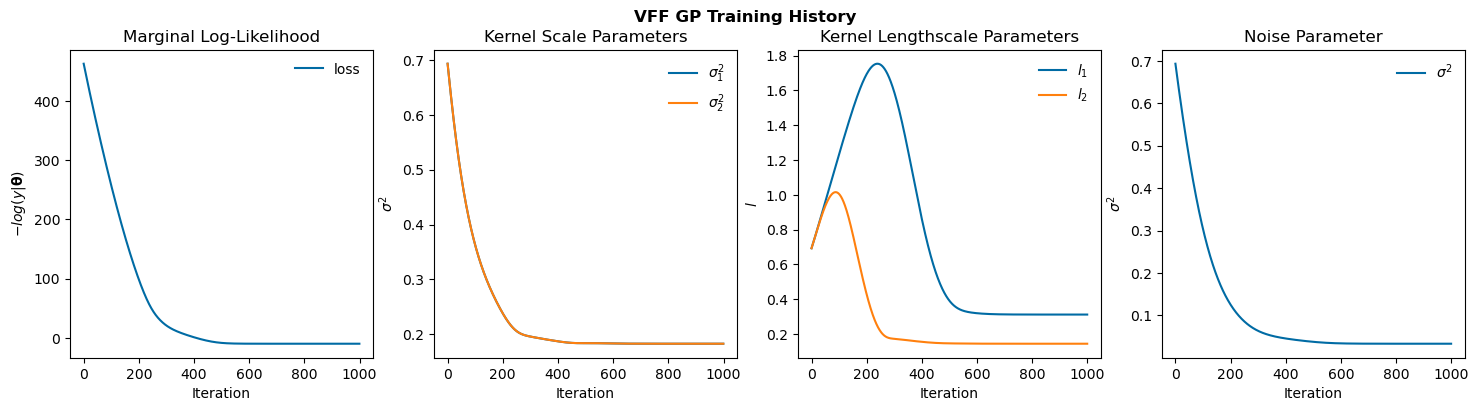

In [431]:
vffgp_training_fig = plot_model_history(vffgp_history, 'VFF GP')

In [432]:
vffgp_training_fig.savefig(os.path.join(results_path, 'vggfp_training_history.png'))

**ASVGP**

In [336]:
PADDING_FACTOR = 0
asvgp = GriddedMatern12ASVGP(X_train, y_train, 
                            N_B0_SPLINES, PADDING_FACTOR, 
                            DIM1_GRID_LIMS, DIM1_GRID_LIMS).to(torch.float64)

In [337]:
asvgp_history = make_training_history_dict(N_ITER)
asvgp_history['learning_rate'] = LEARNING_RATE

In [338]:
# fit the model
optimizer = torch.optim.Adam(asvgp.parameters(), lr=LEARNING_RATE)
for i in tqdm(range(N_ITER)):
    # compute loss
    optimizer.zero_grad()
    elbow = -asvgp._elbo()
    # add to history
    scale_sigma_1 = asvgp.kernel_1.outputscale.item()
    scale_sigma_2 = asvgp.kernel_2.outputscale.item()
    lengthscale_1 = asvgp.kernel_1.base_kernel.lengthscale.item()
    lengthscale_2 = asvgp.kernel_2.base_kernel.lengthscale.item()
    noise = asvgp.likelihood.noise.item()
    # add to history
    asvgp_history['loss'][i] = elbow.item()
    asvgp_history['scale_sigma_1'][i] = scale_sigma_1
    asvgp_history['scale_sigma_2'][i] = scale_sigma_2
    asvgp_history['lengthscale_1'][i] = lengthscale_1
    asvgp_history['lengthscale_2'][i] = lengthscale_2
    asvgp_history['noise'][i] = noise
    # take step
    elbow.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
100%|██████████| 1000/1000 [00:41<00:00, 23.99it/s]


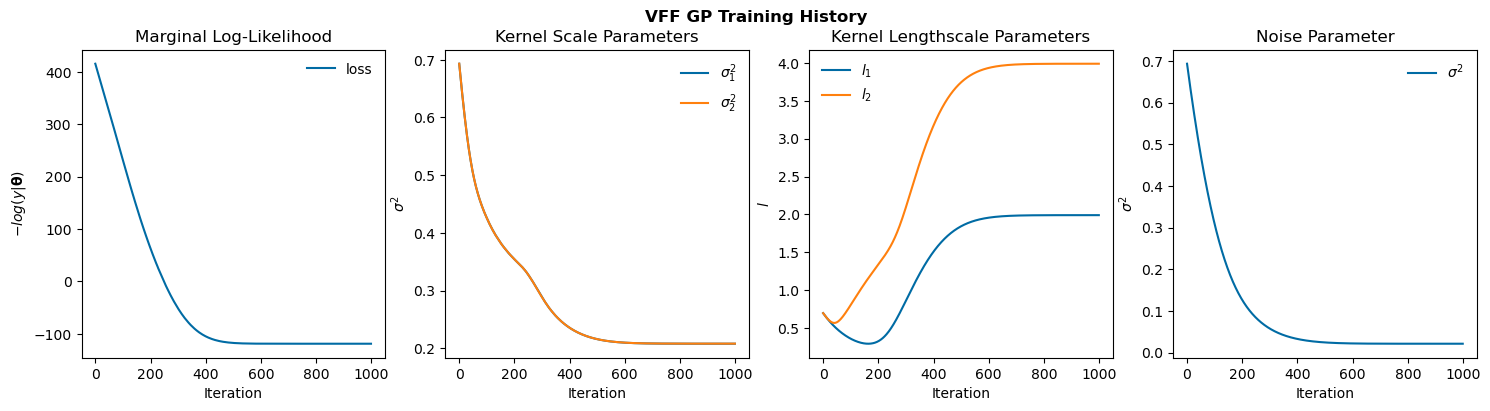

In [340]:
asvgp_training_fig = plot_model_history(asvgp_history, 'VFF GP')

In [433]:
asvgp_training_fig.savefig(os.path.join(results_path, 'asvgp_training_history.png'))

**Gridded GP**

In [341]:
griddedgp = Matern12GriddedGP(
                        X_train, y_train, 
                        N_B0_SPLINES + 1, DIM1_GRID_LIMS, DIM2_GRID_LIMS).to(torch.float64)

In [342]:
griddedgp_history = make_training_history_dict(N_ITER)
griddedgp_history['learning_rate'] = LEARNING_RATE

In [343]:
# fit the model
optimizer = torch.optim.Adam(griddedgp.parameters(), lr=LEARNING_RATE)
for i in tqdm(range(N_ITER)):
    # compute loss
    optimizer.zero_grad()
    elbow = -griddedgp._elbo()
    # add to history
    scale_sigma_1 = griddedgp.kernel_1.outputscale.item()
    scale_sigma_2 = griddedgp.kernel_2.outputscale.item()
    lengthscale_1 = griddedgp.kernel_1.base_kernel.lengthscale.item()
    lengthscale_2 = griddedgp.kernel_2.base_kernel.lengthscale.item()
    noise = griddedgp.likelihood.noise.item()
    # add to history
    griddedgp_history['loss'][i] = elbow.item()
    griddedgp_history['scale_sigma_1'][i] = scale_sigma_1
    griddedgp_history['scale_sigma_2'][i] = scale_sigma_2
    griddedgp_history['lengthscale_1'][i] = lengthscale_1
    griddedgp_history['lengthscale_2'][i] = lengthscale_2
    griddedgp_history['noise'][i] = noise
    # take step
    elbow.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
100%|██████████| 1000/1000 [00:39<00:00, 25.08it/s]


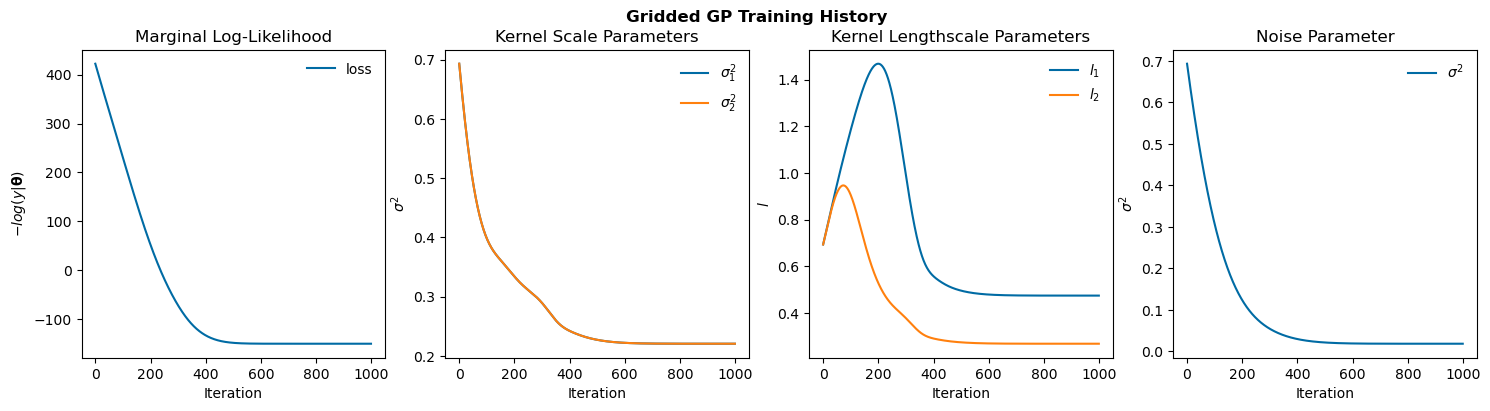

In [346]:
griddedgp_training_fig = plot_model_history(griddedgp_history, 'Gridded GP')

In [434]:
griddedgp_training_fig.savefig(os.path.join(results_path, 'griddedgp_training_history.png'))

# Model Comparison - Training Set

In [347]:
# get the q(v)s
exactgp_grid_pred = exactgp.q_v()
svgp_grid_pred = svgp.q_v()
vffgp_grid_pred = vffgp.q_v()
asvgp_grid_pred = asvgp.q_v()
griddedgp_grid_pred = griddedgp.q_v()

/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


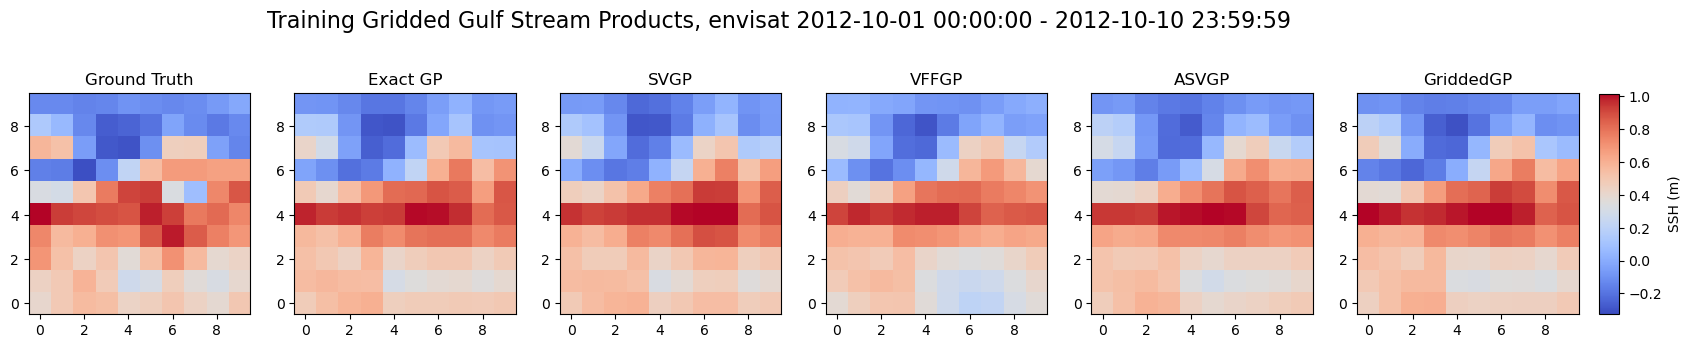

In [435]:
dx1dx2 = (griddedgp.delta_1 * griddedgp.delta_2)
train_start_date = EXP_1_TRAIN['YEAR_FRAME'][0] + '-' + EXP_1_TRAIN['MONTH_FRAME'][0] + '-' + EXP_1_TRAIN['DAY_FRAME'][0] + ' ' + EXP_1_TRAIN['HOUR_FRAME'][0]
train_end_date = EXP_1_TRAIN['YEAR_FRAME'][1] + '-' + EXP_1_TRAIN['MONTH_FRAME'][1] + '-' + EXP_1_TRAIN['DAY_FRAME'][1] + ' ' + EXP_1_TRAIN['HOUR_FRAME'][1]

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20, 4))
plt.suptitle('Training Gridded Gulf Stream Products, {} {} - {}'.format(EXP_1_TRAIN['SATELLITE'], train_start_date, train_end_date), fontsize=16)
# ground truth
ax1.set_title('Ground Truth')
ground_grid_y = train_grid * dx1dx2
im1 = ax1.imshow(ground_grid_y, cmap='coolwarm', origin='lower', vmin=-.0025, vmax=0.01)
# exact GP
ax2.set_title('Exact GP')
exactgp_grid_y = exactgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T #/ dx1dx2
im2 = ax2.imshow(exactgp_grid_y, cmap='coolwarm', origin='lower', vmin=-.0025, vmax=0.01) #, vmin=-.26, vmax=1)
# SVGP
ax3.set_title('SVGP')
svgp_grid_y = svgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T # / dx1dx2
im3 = ax3.imshow(svgp_grid_y, cmap='coolwarm', origin='lower', vmin=-.0025, vmax=0.01) #, vmin=-.26, vmax=1)
# VFFGP
ax4.set_title('VFFGP')
vffgp_grid_y = vffgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T # / dx1dx2
im4 = ax4.imshow(vffgp_grid_y, cmap='coolwarm', origin='lower', vmin=-.0025, vmax=0.01) #, vmin=-.26, vmax=1)
# ASVGP
ax5.set_title('ASVGP')
asvgp_grid_y = asvgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T # / dx1dx2
im5 = ax5.imshow(asvgp_grid_y, cmap='coolwarm', origin='lower', vmin=-.0025, vmax=0.01) #, vmin=-.26, vmax=1)
# GriddedGP
ax6.set_title('GriddedGP')
griddedgp_grid_y = griddedgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T # / dx1dx2
im6 = ax6.imshow(griddedgp_grid_y, cmap='coolwarm', origin='lower', vmin=-.0025, vmax=0.01) #, vmin=-.26, vmax=1)
# color bar
cax = fig.add_axes([0.91, 0.22, 0.01, 0.55])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax)
cbar.set_label('SSH (m)')

In [436]:
fig.savefig(os.path.join(results_path, 'train_data_model_gridded_prediction.png'))

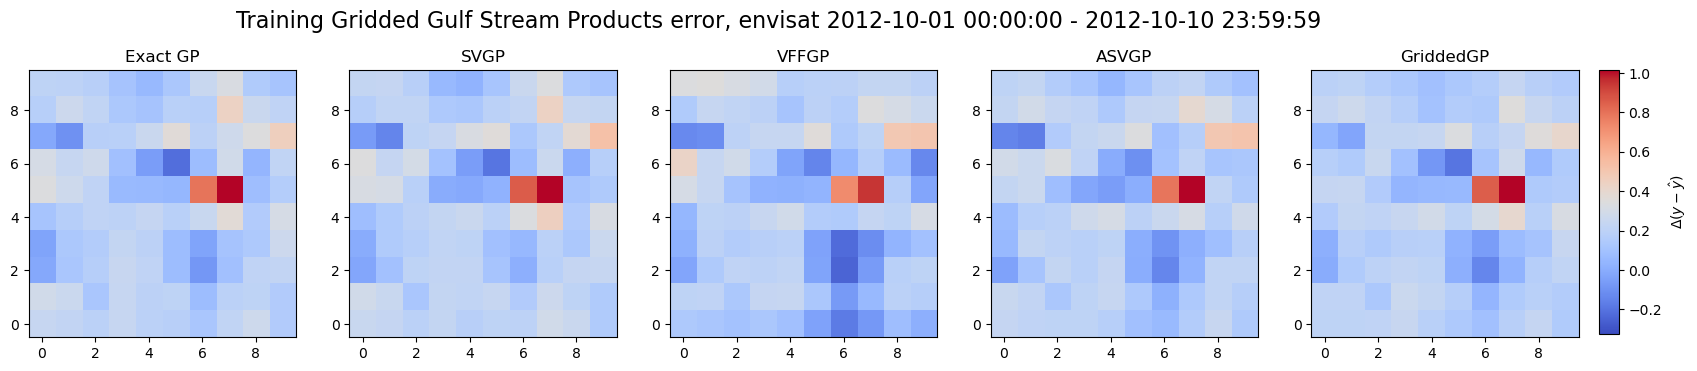

In [437]:
dx1dx2 = (griddedgp.delta_1 * griddedgp.delta_2)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))
plt.suptitle('Training Gridded Gulf Stream Products error, {} {} - {}'.format(EXP_1_TRAIN['SATELLITE'], train_start_date, train_end_date), fontsize=16)
# exact GP
ax1.set_title('Exact GP')
exactgp_grid_y = exactgp_grid_pred.mean.detach().reshape(N_B0_SPLINES, N_B0_SPLINES).T
im1 = ax1.imshow(exactgp_grid_y - ground_grid_y, cmap='coolwarm', origin='lower', vmin=-.004, vmax=.007) #, vmin=-.26, vmax=1)
# SVGP
ax2.set_title('SVGP')
svgp_grid_y = svgp_grid_pred.mean.detach().reshape(N_B0_SPLINES, N_B0_SPLINES).T 
im2 = ax2.imshow(svgp_grid_y - ground_grid_y, cmap='coolwarm', origin='lower', vmin=-.004, vmax=.007) #, vmin=-.26, vmax=1)
# VFFGP
ax3.set_title('VFFGP')
vffgp_grid_y = vffgp_grid_pred.mean.detach().reshape(N_B0_SPLINES, N_B0_SPLINES).T 
im3 = ax3.imshow(vffgp_grid_y - ground_grid_y, cmap='coolwarm', origin='lower', vmin=-.004, vmax=.007) #, vmin=-.26, vmax=1)
# ASVGP
ax4.set_title('ASVGP')
asvgp_grid_y = asvgp_grid_pred.mean.detach().reshape(N_B0_SPLINES, N_B0_SPLINES).T 
im4 = ax4.imshow(asvgp_grid_y - ground_grid_y, cmap='coolwarm', origin='lower', vmin=-.004, vmax=.007) #, vmin=-.26, vmax=1)
# GriddedGP
ax5.set_title('GriddedGP')
griddedgp_grid_y = griddedgp_grid_pred.mean.detach().reshape(N_B0_SPLINES, N_B0_SPLINES).T
im5 = ax5.imshow(griddedgp_grid_y - ground_grid_y, cmap='coolwarm', origin='lower', vmin=-.004, vmax=.007) #, vmin=-.26, vmax=1)
# colorbar
cax = fig.add_axes([0.91, 0.17, 0.01, 0.66])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax)
cbar.set_label(r'$\Delta(y - \hat{y})$')


In [438]:
fig.savefig(os.path.join(results_path, 'train_data_model_gridded_prediction_error.png'))

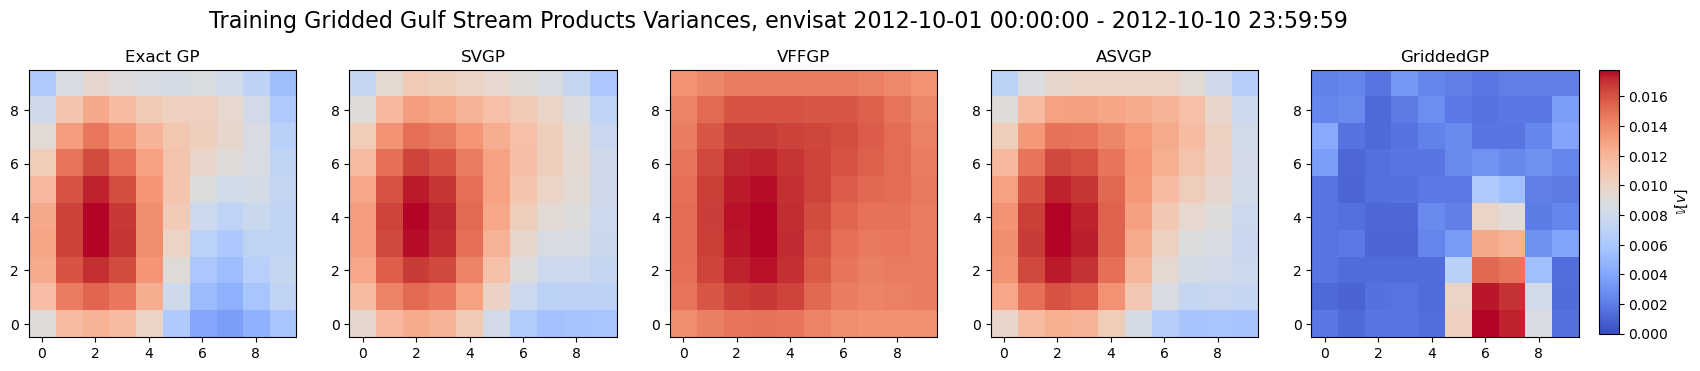

In [439]:
dx1dx2 = (griddedgp.delta_1 * griddedgp.delta_2)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))
plt.suptitle('Training Gridded Gulf Stream Products Variances, {} {} - {}'.format(EXP_1_TRAIN['SATELLITE'], train_start_date, train_end_date), fontsize=16)
# exact GP
ax1.set_title('Exact GP')
exactgp_grid_cov = torch.diagonal(exactgp_grid_pred.covariance_matrix.detach()).reshape(N_B0_SPLINES, N_B0_SPLINES).T
im1 = ax1.imshow(exactgp_grid_cov, cmap='coolwarm', origin='lower', vmin =0) #, vmin=-.26, vmax=1)
# SVGP
ax2.set_title('SVGP')
svgp_grid_cov = torch.diagonal(svgp_grid_pred.covariance_matrix.detach()).reshape(N_B0_SPLINES, N_B0_SPLINES).T
im2 = ax2.imshow(svgp_grid_cov, cmap='coolwarm', origin='lower', vmin =0)
# VFFGP
ax3.set_title('VFFGP')
vffgp_grid_cov = torch.diagonal(vffgp_grid_pred.covariance_matrix.detach()).reshape(N_B0_SPLINES, N_B0_SPLINES).T
im3 = ax3.imshow(vffgp_grid_cov, cmap='coolwarm', origin='lower', vmin =0)
# ASVGP
ax4.set_title('ASVGP')
asvgp_grid_cov = torch.diagonal(asvgp_grid_pred.covariance_matrix.detach()).reshape(N_B0_SPLINES, N_B0_SPLINES).T
im4 = ax4.imshow(asvgp_grid_cov, cmap='coolwarm', origin='lower', vmin =0)
# GriddedGP
ax5.set_title('GriddedGP')
griddedgp_grid_cov = torch.diagonal(griddedgp_grid_pred.covariance_matrix.detach()).reshape(N_B0_SPLINES, N_B0_SPLINES).T
im5 = ax5.imshow(griddedgp_grid_cov, cmap='coolwarm', origin='lower', vmin =0)
# colorbar
cax = fig.add_axes([0.91, 0.17, 0.01, 0.66])  # Adjust the position as needed
cbar = plt.colorbar(im1, cax=cax)
cbar.set_label(r'$\mathbb{V}[v]$')


In [440]:
fig.savefig(os.path.join(results_path, 'train_data_model_gridded_prediction_variance.png'))

In [441]:
exp1_eval_df = pd.DataFrame({
    'exactgp' : evaluation_metric_row(ground_grid_y, exactgp_grid_pred),
    'svgp' : evaluation_metric_row(ground_grid_y, svgp_grid_pred),
    'vffgp' : evaluation_metric_row(ground_grid_y, vffgp_grid_pred),
    'asvgp' : evaluation_metric_row(ground_grid_y, asvgp_grid_pred),
    'griddedgp' : evaluation_metric_row(ground_grid_y, griddedgp_grid_pred)}, index = ['mse', 'mae', 'rmse', 'r2', 'nlpd', 'msll'])

In [442]:
exp1_eval_df

,exactgp,svgp,vffgp,asvgp,griddedgp
mse,0.000002,0.000002,0.000002,0.000002,0.000002
mae,0.000801,0.000864,0.000993,0.000856,0.000735
rmse,0.001259,0.001366,0.001431,0.001315,0.001259
r2,0.873316,0.850872,0.836356,0.861933,0.873451
nlpd,-3.965745,-3.264299,-4.036063,76.003955,-4.236367
msll,-1.395192,-2.016535,-3.213884,-3.072221,-4.403152


# Model Comparison - Test Data

**Exact GP**

In [445]:
exactgp_test = GriddedMatern12ExactGP(
                        train_x = X_test, train_y = y_test,   
                        n_b0_splines = N_B0_SPLINES,
                        dim1_grid_lims = DIM1_GRID_LIMS, dim2_grid_lims = DIM2_GRID_LIMS,).to(torch.float64)

In [446]:
exactgp_history_test = make_training_history_dict(N_ITER)
exactgp_history_test['learning_rate'] = LEARNING_RATE

In [447]:
# set model and likelihood into training mode
exactgp_test.train()
exactgp_test.likelihood.train()
# define the optimizer
optimizer = torch.optim.Adam(exactgp_test.parameters(), lr = LEARNING_RATE)
# define the mll
mll = gpytorch.mlls.ExactMarginalLogLikelihood(exactgp_test.likelihood, exactgp)
for i in tqdm(range(N_ITER)):
    optimizer.zero_grad()
    output = exactgp_test(exactgp_test.train_x)
    loss = -mll(output, exactgp_test.train_y)
    scale_sigma_1 = exactgp_test.kernel_1.outputscale.item()
    scale_sigma_2 = exactgp_test.kernel_2.outputscale.item()
    lengthscale_1 = exactgp_test.kernel_1.base_kernel.lengthscale.item()
    lengthscale_2 = exactgp_test.kernel_2.base_kernel.lengthscale.item()
    noise = exactgp_test.likelihood.noise.item()
    # add to history
    exactgp_history_test['loss'][i] = loss.item()
    exactgp_history_test['scale_sigma_1'][i] = scale_sigma_1
    exactgp_history_test['scale_sigma_2'][i] = scale_sigma_2
    exactgp_history_test['lengthscale_1'][i] = lengthscale_1
    exactgp_history_test['lengthscale_2'][i] = lengthscale_2
    exactgp_history_test['noise'][i] = noise
    # take step
    loss.backward()
    optimizer.step()

100%|██████████| 1000/1000 [00:16<00:00, 61.28it/s]


**SVGP**

In [448]:
inducing_points = torch.tensor(np.random.rand(100, 2), dtype=torch.float64)
svgp_test = GriddedMatern12SVGP(
                X_test, y_test, inducing_points, # data part
                n_b0_splines = N_B0_SPLINES, # vff part
                dim1_grid_lims = DIM1_GRID_LIMS, dim2_grid_lims = DIM2_GRID_LIMS).to(torch.float64) # spline part

In [449]:
svgp_history_test = make_training_history_dict(N_ITER)
svgp_history_test['learning_rate'] = LEARNING_RATE

In [450]:
# fit the model
optimizer = torch.optim.Adam(svgp_test.parameters(), lr=LEARNING_RATE)
for i in tqdm(range(N_ITER)):
    # compute loss
    optimizer.zero_grad()
    elbow = -svgp_test._elbo()
    # add to history
    scale_sigma_1 = svgp_test.kernel_1.outputscale.item()
    scale_sigma_2 = svgp_test.kernel_2.outputscale.item()
    lengthscale_1 = svgp_test.kernel_1.base_kernel.lengthscale.item()
    lengthscale_2 = svgp_test.kernel_2.base_kernel.lengthscale.item()
    noise = svgp_test.likelihood.noise.item()
    # add to history
    svgp_history_test['loss'][i] = elbow.item()
    svgp_history_test['scale_sigma_1'][i] = scale_sigma_1
    svgp_history_test['scale_sigma_2'][i] = scale_sigma_2
    svgp_history_test['lengthscale_1'][i] = lengthscale_1
    svgp_history_test['lengthscale_2'][i] = lengthscale_2
    svgp_history_test['noise'][i] = noise
    # take step
    elbow.backward()
    optimizer.step()
    


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
100%|██████████| 1000/1000 [00:40<00:00, 24.80it/s]


**VFFGP**

In [451]:
N_OMEGAS =  5
vffgp_test = GriddedMatern12VFFGP(
                    X_test, y_test, 
                    N_OMEGAS, DIM1_GRID_LIMS, DIM2_GRID_LIMS,
                    N_B0_SPLINES, DIM1_GRID_LIMS, DIM2_GRID_LIMS).to(torch.float64) # spline part

In [452]:
vffgp_history_test = make_training_history_dict(N_ITER)
vffgp_history_test['learning_rate'] = LEARNING_RATE

In [453]:
# fit the model
optimizer = torch.optim.Adam(vffgp_test.parameters(), lr=LEARNING_RATE)
for i in tqdm(range(N_ITER)):
    # compute loss
    optimizer.zero_grad()
    elbow = -vffgp_test._elbo()
    # add to history
    scale_sigma_1 = vffgp_test.kernel_1.outputscale.item()
    scale_sigma_2 = vffgp_test.kernel_2.outputscale.item()
    lengthscale_1 = vffgp_test.kernel_1.base_kernel.lengthscale.item()
    lengthscale_2 = vffgp_test.kernel_2.base_kernel.lengthscale.item()
    noise = vffgp_test.likelihood.noise.item()
    # add to history
    vffgp_history_test['loss'][i] = elbow.item()
    vffgp_history_test['scale_sigma_1'][i] = scale_sigma_1
    vffgp_history_test['scale_sigma_2'][i] = scale_sigma_2
    vffgp_history_test['lengthscale_1'][i] = lengthscale_1
    vffgp_history_test['lengthscale_2'][i] = lengthscale_2
    vffgp_history_test['noise'][i] = noise
    # take step
    elbow.backward()
    optimizer.step()

100%|██████████| 1000/1000 [01:49<00:00,  9.09it/s]


**ASVGP**

In [455]:
PADDING_FACTOR = 0
asvgp_test = GriddedMatern12ASVGP(X_test, y_test, 
                            N_B0_SPLINES, PADDING_FACTOR, 
                            DIM1_GRID_LIMS, DIM1_GRID_LIMS).to(torch.float64)

In [456]:
asvgp_history_test = make_training_history_dict(N_ITER)
asvgp_history_test['learning_rate'] = LEARNING_RATE

In [457]:
# fit the model
optimizer = torch.optim.Adam(asvgp_test.parameters(), lr=LEARNING_RATE)
for i in tqdm(range(N_ITER)):
    # compute loss
    optimizer.zero_grad()
    elbow = -asvgp_test._elbo()
    # add to history
    scale_sigma_1 = asvgp_test.kernel_1.outputscale.item()
    scale_sigma_2 = asvgp_test.kernel_2.outputscale.item()
    lengthscale_1 = asvgp_test.kernel_1.base_kernel.lengthscale.item()
    lengthscale_2 = asvgp_test.kernel_2.base_kernel.lengthscale.item()
    noise = asvgp_test.likelihood.noise.item()
    # add to history
    asvgp_history_test['loss'][i] = elbow.item()
    asvgp_history_test['scale_sigma_1'][i] = scale_sigma_1
    asvgp_history_test['scale_sigma_2'][i] = scale_sigma_2
    asvgp_history_test['lengthscale_1'][i] = lengthscale_1
    asvgp_history_test['lengthscale_2'][i] = lengthscale_2
    asvgp_history_test['noise'][i] = noise
    # take step
    elbow.backward()
    optimizer.step()

100%|██████████| 1000/1000 [00:39<00:00, 25.08it/s]


**GriddedGP**

In [458]:
griddedgp_test = Matern12GriddedGP(
                        X_test, y_test, 
                        N_B0_SPLINES + 1, DIM1_GRID_LIMS, DIM2_GRID_LIMS).to(torch.float64)

In [459]:
griddedgp_history_test = make_training_history_dict(N_ITER)
griddedgp_history_test['learning_rate'] = LEARNING_RATE

In [460]:
# fit the model
optimizer = torch.optim.Adam(griddedgp_test.parameters(), lr=LEARNING_RATE)
for i in tqdm(range(N_ITER)):
    # compute loss
    optimizer.zero_grad()
    elbow = -griddedgp_test._elbo()
    # add to history
    scale_sigma_1 = griddedgp_test.kernel_1.outputscale.item()
    scale_sigma_2 = griddedgp_test.kernel_2.outputscale.item()
    lengthscale_1 = griddedgp_test.kernel_1.base_kernel.lengthscale.item()
    lengthscale_2 = griddedgp_test.kernel_2.base_kernel.lengthscale.item()
    noise = griddedgp_test.likelihood.noise.item()
    # add to history
    griddedgp_history_test['loss'][i] = elbow.item()
    griddedgp_history_test['scale_sigma_1'][i] = scale_sigma_1
    griddedgp_history_test['scale_sigma_2'][i] = scale_sigma_2
    griddedgp_history_test['lengthscale_1'][i] = lengthscale_1
    griddedgp_history_test['lengthscale_2'][i] = lengthscale_2
    griddedgp_history_test['noise'][i] = noise
    # take step
    elbow.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
100%|██████████| 1000/1000 [00:33<00:00, 30.08it/s]


## Model Comparison

In [461]:
# get the q(v)s
exactgp_grid_pred = exactgp_test.q_v()
svgp_grid_pred = svgp_test.q_v()
vffgp_grid_pred = vffgp_test.q_v()
asvgp_grid_pred = asvgp_test.q_v()
griddedgp_grid_pred = griddedgp_test.q_v()

/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


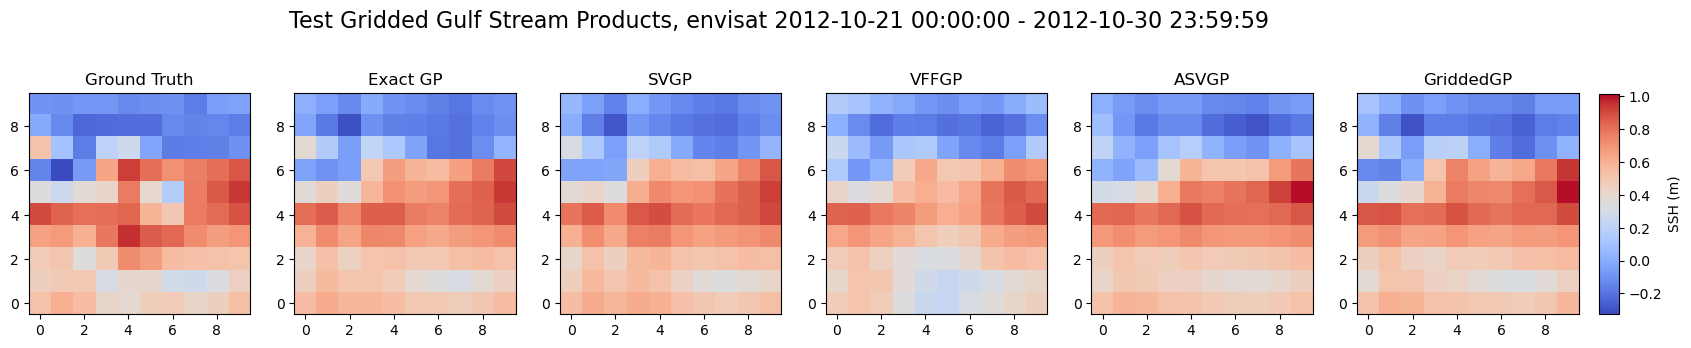

In [464]:
dx1dx2 = (griddedgp_test.delta_1 * griddedgp_test.delta_2)
test_start_date = EXP_1_TEST['YEAR_FRAME'][0] + '-' + EXP_1_TEST['MONTH_FRAME'][0] + '-' + EXP_1_TEST['DAY_FRAME'][0] + ' ' + EXP_1_TEST['HOUR_FRAME'][0]
test_end_date = EXP_1_TEST['YEAR_FRAME'][1] + '-' + EXP_1_TEST['MONTH_FRAME'][1] + '-' + EXP_1_TEST['DAY_FRAME'][1] + ' ' + EXP_1_TEST['HOUR_FRAME'][1]

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20, 4))
plt.suptitle('Test Gridded Gulf Stream Products, {} {} - {}'.format(EXP_1_TRAIN['SATELLITE'], test_start_date, test_end_date), fontsize=16)
# ground truth
ax1.set_title('Ground Truth')
ground_grid_y = test_grid * dx1dx2
im1 = ax1.imshow(ground_grid_y, cmap='coolwarm', origin='lower', vmin=-.0025, vmax=0.01)
# exact GP
ax2.set_title('Exact GP')
exactgp_grid_y = exactgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T #/ dx1dx2
im2 = ax2.imshow(exactgp_grid_y, cmap='coolwarm', origin='lower', vmin=-.0025, vmax=0.01) #, vmin=-.26, vmax=1)
# SVGP
ax3.set_title('SVGP')
svgp_grid_y = svgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T # / dx1dx2
im3 = ax3.imshow(svgp_grid_y, cmap='coolwarm', origin='lower', vmin=-.0025, vmax=0.01) #, vmin=-.26, vmax=1)
# VFFGP
ax4.set_title('VFFGP')
vffgp_grid_y = vffgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T # / dx1dx2
im4 = ax4.imshow(vffgp_grid_y, cmap='coolwarm', origin='lower', vmin=-.0025, vmax=0.01) #, vmin=-.26, vmax=1)
# ASVGP
ax5.set_title('ASVGP')
asvgp_grid_y = asvgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T # / dx1dx2
im5 = ax5.imshow(asvgp_grid_y, cmap='coolwarm', origin='lower', vmin=-.0025, vmax=0.01) #, vmin=-.26, vmax=1)
# GriddedGP
ax6.set_title('GriddedGP')
griddedgp_grid_y = griddedgp_grid_pred.mean.detach().numpy().reshape(N_B0_SPLINES, N_B0_SPLINES).T # / dx1dx2
im6 = ax6.imshow(griddedgp_grid_y, cmap='coolwarm', origin='lower', vmin=-.0025, vmax=0.01) #, vmin=-.26, vmax=1)
# color bar
cax = fig.add_axes([0.91, 0.22, 0.01, 0.55])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax)
cbar.set_label('SSH (m)')

In [465]:
fig.savefig(os.path.join(results_path, 'test_data_model_gridded_prediction.png'))

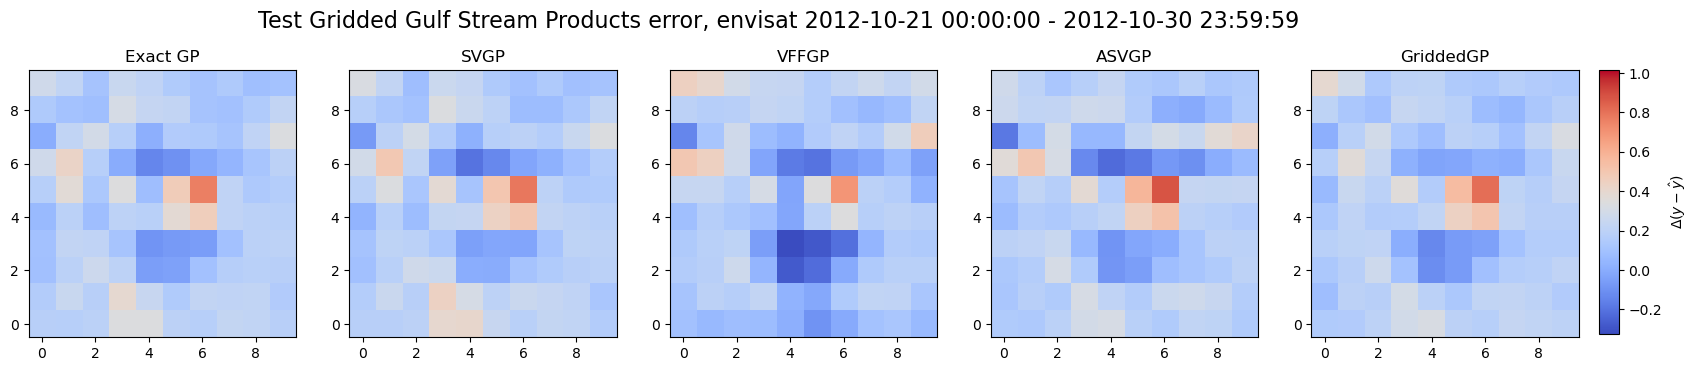

In [466]:
dx1dx2 = (griddedgp_test.delta_1 * griddedgp_test.delta_2)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))
plt.suptitle('Test Gridded Gulf Stream Products error, {} {} - {}'.format(EXP_1_TEST['SATELLITE'], test_start_date, test_end_date), fontsize=16)
# exact GP
ax1.set_title('Exact GP')
exactgp_grid_y = exactgp_grid_pred.mean.detach().reshape(N_B0_SPLINES, N_B0_SPLINES).T
im1 = ax1.imshow(exactgp_grid_y - ground_grid_y, cmap='coolwarm', origin='lower', vmin=-.004, vmax=.007) #, vmin=-.26, vmax=1)
# SVGP
ax2.set_title('SVGP')
svgp_grid_y = svgp_grid_pred.mean.detach().reshape(N_B0_SPLINES, N_B0_SPLINES).T 
im2 = ax2.imshow(svgp_grid_y - ground_grid_y, cmap='coolwarm', origin='lower', vmin=-.004, vmax=.007) #, vmin=-.26, vmax=1)
# VFFGP
ax3.set_title('VFFGP')
vffgp_grid_y = vffgp_grid_pred.mean.detach().reshape(N_B0_SPLINES, N_B0_SPLINES).T 
im3 = ax3.imshow(vffgp_grid_y - ground_grid_y, cmap='coolwarm', origin='lower', vmin=-.004, vmax=.007) #, vmin=-.26, vmax=1)
# ASVGP
ax4.set_title('ASVGP')
asvgp_grid_y = asvgp_grid_pred.mean.detach().reshape(N_B0_SPLINES, N_B0_SPLINES).T 
im4 = ax4.imshow(asvgp_grid_y - ground_grid_y, cmap='coolwarm', origin='lower', vmin=-.004, vmax=.007) #, vmin=-.26, vmax=1)
# GriddedGP
ax5.set_title('GriddedGP')
griddedgp_grid_y = griddedgp_grid_pred.mean.detach().reshape(N_B0_SPLINES, N_B0_SPLINES).T
im5 = ax5.imshow(griddedgp_grid_y - ground_grid_y, cmap='coolwarm', origin='lower', vmin=-.004, vmax=.007) #, vmin=-.26, vmax=1)
# colorbar
cax = fig.add_axes([0.91, 0.17, 0.01, 0.66])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax)
cbar.set_label(r'$\Delta(y - \hat{y})$')


In [467]:
fig.savefig(os.path.join(results_path, 'test_data_model_gridded_prediction_error.png'))

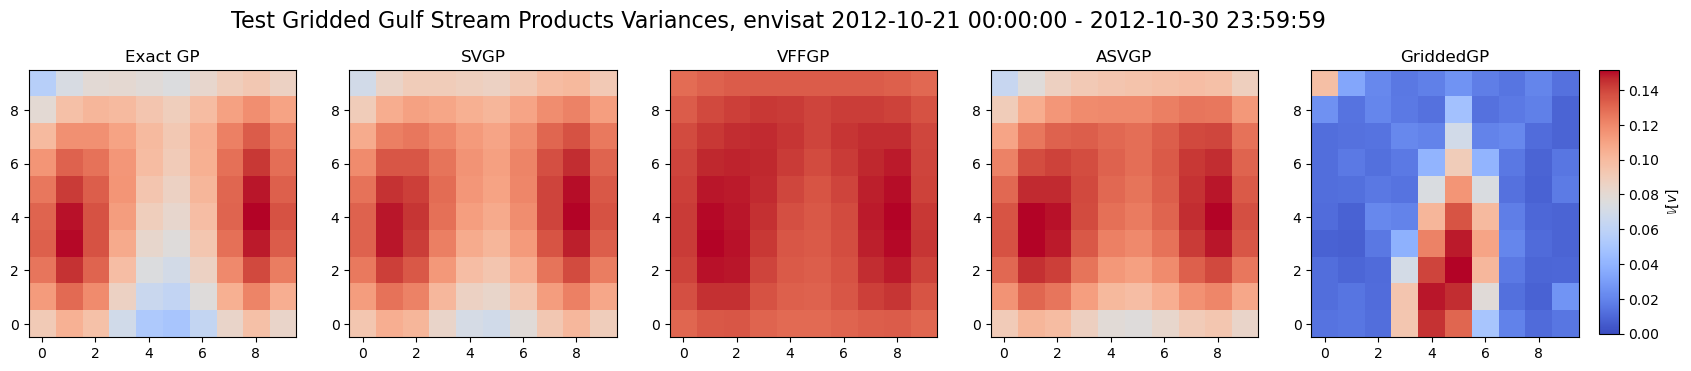

In [468]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))
plt.suptitle('Test Gridded Gulf Stream Products Variances, {} {} - {}'.format(EXP_1_TEST['SATELLITE'], test_start_date, test_end_date), fontsize=16)
# exact GP
ax1.set_title('Exact GP')
exactgp_grid_cov = torch.diagonal(exactgp_grid_pred.covariance_matrix.detach()).reshape(N_B0_SPLINES, N_B0_SPLINES).T
im1 = ax1.imshow(exactgp_grid_cov, cmap='coolwarm', origin='lower', vmin =0) #, vmin=-.26, vmax=1)
# SVGP
ax2.set_title('SVGP')
svgp_grid_cov = torch.diagonal(svgp_grid_pred.covariance_matrix.detach()).reshape(N_B0_SPLINES, N_B0_SPLINES).T
im2 = ax2.imshow(svgp_grid_cov, cmap='coolwarm', origin='lower', vmin =0)
# VFFGP
ax3.set_title('VFFGP')
vffgp_grid_cov = torch.diagonal(vffgp_grid_pred.covariance_matrix.detach()).reshape(N_B0_SPLINES, N_B0_SPLINES).T
im3 = ax3.imshow(vffgp_grid_cov, cmap='coolwarm', origin='lower', vmin =0)
# ASVGP
ax4.set_title('ASVGP')
asvgp_grid_cov = torch.diagonal(asvgp_grid_pred.covariance_matrix.detach()).reshape(N_B0_SPLINES, N_B0_SPLINES).T
im4 = ax4.imshow(asvgp_grid_cov, cmap='coolwarm', origin='lower', vmin =0)
# GriddedGP
ax5.set_title('GriddedGP')
griddedgp_grid_cov = torch.diagonal(griddedgp_grid_pred.covariance_matrix.detach()).reshape(N_B0_SPLINES, N_B0_SPLINES).T
im5 = ax5.imshow(griddedgp_grid_cov, cmap='coolwarm', origin='lower', vmin =0)
# colorbar
cax = fig.add_axes([0.91, 0.17, 0.01, 0.66])  # Adjust the position as needed
cbar = plt.colorbar(im1, cax=cax)
cbar.set_label(r'$\mathbb{V}[v]$')


In [471]:
fig.savefig(os.path.join(results_path, 'test_data_model_gridded_prediction_variance.png'))

In [472]:
exp1_eval_df_test = pd.DataFrame({
    'exactgp' : evaluation_metric_row(ground_grid_y, exactgp_grid_pred),
    'svgp' : evaluation_metric_row(ground_grid_y, svgp_grid_pred),
    'vffgp' : evaluation_metric_row(ground_grid_y, vffgp_grid_pred),
    'asvgp' : evaluation_metric_row(ground_grid_y, asvgp_grid_pred),
    'griddedgp' : evaluation_metric_row(ground_grid_y, griddedgp_grid_pred)}, index = ['mse', 'mae', 'rmse', 'r2', 'nlpd', 'msll'])

In [473]:
exp1_eval_df_test

,exactgp,svgp,vffgp,asvgp,griddedgp
mse,0.000001,0.000001,0.000002,0.000002,0.000001
mae,0.000734,0.000809,0.000986,0.000879,0.000694
rmse,0.001057,0.001156,0.001393,0.001293,0.001062
r2,0.906788,0.888568,0.838087,0.860509,0.905986
nlpd,-3.634579,-3.364081,-3.937365,51.637873,-4.478903
msll,-0.218513,-1.851059,-3.190955,-2.916271,-5.198702
